# Uncertainty Quantification

Uncertainty Quantification Example for JAXSR.

Demonstrates the full range of UQ capabilities:
1. Classical OLS intervals (coefficient CIs, prediction/confidence bands)
2. Pareto front ensemble predictions
3. Bayesian Model Averaging
4. Conformal prediction (split and jackknife+)
5. Residual bootstrap
6. UQ visualization

In [1]:
import jax.numpy as jnp
import numpy as np
from jaxsr import (
    BasisLibrary,
    BayesianModelAverage,
    SymbolicRegressor,
    bootstrap_coefficients,
    bootstrap_predict,
)

## Classical OLS prediction and confidence intervals.

**True model:** $$y = 2x + 1 + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.5^2)$$

Since JAXSR models are linear-in-parameters (y = Phi @ beta),
    standard OLS inference applies directly:
      - Cov(beta) = s^2 * (Phi^T Phi)^{-1}
      - Prediction variance = s^2 * (1 + h(x_new))

In [2]:
# Generate known model: y = 2*x + 1 + noise
np.random.seed(42)
n = 100
X = np.random.uniform(0, 5, (n, 1))
y_true = 2.0 * X[:, 0] + 1.0
y = y_true + np.random.randn(n) * 0.5

X_jax = jnp.array(X)
y_jax = jnp.array(y)

# Fit model
library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=3,
    strategy="greedy_forward",
)
model.fit(X_jax, y_jax)

print("\nTrue model: y = 2*x + 1 (noise std = 0.5)")
print(f"Discovered: {model.expression_}")

# Noise estimate
print(f"\nEstimated noise (sigma): {model.sigma_:.4f} (true: 0.5)")

# Coefficient intervals
print("\nCoefficient 95% confidence intervals:")
intervals = model.coefficient_intervals(alpha=0.05)
for name, (est, lo, hi, se) in intervals.items():
    print(f"  {name}: {est:.4f} [{lo:.4f}, {hi:.4f}]  (SE={se:.4f})")

# Prediction intervals on new data
X_new = jnp.linspace(0, 5, 5).reshape(-1, 1)
y_pred, pred_lo, pred_hi = model.predict_interval(X_new, alpha=0.05)
y_pred_c, conf_lo, conf_hi = model.confidence_band(X_new, alpha=0.05)

print("\nPrediction and confidence intervals at selected points:")
print(
    f"  {'x':>5}  {'y_pred':>8}  {'pred_lo':>8}  {'pred_hi':>8}  {'conf_lo':>8}  {'conf_hi':>8}"
)
for i in range(len(X_new)):
    print(
        f"  {float(X_new[i, 0]):5.1f}  "
        f"{float(y_pred[i]):8.3f}  "
        f"{float(pred_lo[i]):8.3f}  "
        f"{float(pred_hi[i]):8.3f}  "
        f"{float(conf_lo[i]):8.3f}  "
        f"{float(conf_hi[i]):8.3f}"
    )

print("\nNote: Confidence band is narrower — it estimates E[y|x], not a new y.")

# Covariance matrix
cov = model.covariance_matrix_
print("\nCoefficient covariance matrix:")
print(f"  {np.array(cov)}")


True model: y = 2*x + 1 (noise std = 0.5)
Discovered: y = 1.954*x + 1.108

Estimated noise (sigma): 0.4536 (true: 0.5)

Coefficient 95% confidence intervals:


  x: 1.9540 [1.8932, 2.0148]  (SE=0.0306)
  1: 1.1075 [0.9386, 1.2765]  (SE=0.0851)

Prediction and confidence intervals at selected points:
      x    y_pred   pred_lo   pred_hi   conf_lo   conf_hi
    0.0     1.108     0.192     2.023     0.939     1.277
    1.2     3.550     2.643     4.457     3.438     3.662
    2.5     5.993     5.088     6.897     5.902     6.083
    3.8     8.435     7.526     9.344     8.311     8.559
    5.0    10.878     9.959    11.797    10.693    11.062

Note: Confidence band is narrower — it estimates E[y|x], not a new y.

Coefficient covariance matrix:
  [[ 0.00093939 -0.00220841]
 [-0.00220841  0.00724938]]


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                x     1.9540    0.0306    63.75   0.00e+00 [1.8932, 2.0148] ***
                1     1.1075    0.0851    13.01   0.00e+00 [0.9386, 1.2765] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


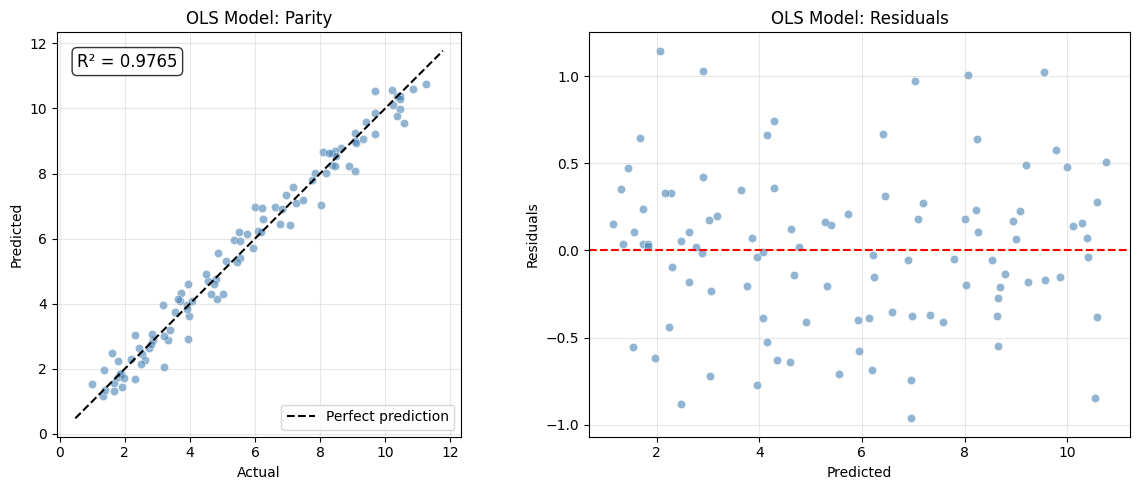


ANOVA Table (OLS Model)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  x                             1      801.5128      801.5128     3895.35      0.0000
  1                             1       34.8167       34.8167      169.21      0.0000
  Model                         1      836.3295      836.3295     4064.56      0.0000
  Residual                     98       20.1646        0.2058                        
  Total                        99      856.4941        8.6515                        
--------------------------------------------------------------------------------

Variance Contributions:
  x                            95.8%  ***
  1                             4.2%  ***


In [3]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
from jaxsr import anova
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y_jax)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X_jax)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y_jax, y_pred, ax=axes[0], title="OLS Model: Parity")
residuals = np.array(y_jax - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("OLS Model: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (OLS Model)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Pareto front ensemble predictions.

Measures structural/model uncertainty: how much do predictions
    vary across plausible model complexities?

In [4]:
np.random.seed(42)
X = np.random.uniform(-2, 3, (100, 1))
y = 1.5 * X[:, 0] ** 2 - 0.5 * X[:, 0] + 2.0 + np.random.randn(100) * 0.5

library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=4)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
)
model.fit(jnp.array(X), jnp.array(y))

print(f"\nBest model: {model.expression_}")

# Pareto front models
print("\nPareto front models:")
for r in model.pareto_front_:
    print(f"  Complexity {r.complexity}: {r.expression()}")

# Ensemble predictions
X_new = jnp.linspace(-2, 3, 5).reshape(-1, 1)
result = model.predict_ensemble(X_new)

print("\nEnsemble predictions at selected points:")
print(f"  {'x':>5}  {'mean':>8}  {'std':>8}  {'min':>8}  {'max':>8}")
for i in range(len(X_new)):
    print(
        f"  {float(X_new[i, 0]):5.1f}  "
        f"{float(result['y_mean'][i]):8.3f}  "
        f"{float(result['y_std'][i]):8.3f}  "
        f"{float(result['y_min'][i]):8.3f}  "
        f"{float(result['y_max'][i]):8.3f}"
    )


Best model: y = 1.546*x^2 + 1.922 - 0.5863*x

Pareto front models:
  Complexity 2: y = 1.326*x^2 + 2.227
  Complexity 3: y = 1.546*x^2 + 1.922 - 0.5863*x

Ensemble predictions at selected points:
      x      mean       std       min       max
   -2.0     8.406     0.875     7.530     9.281
   -0.8     3.102     0.130     2.973     3.232
    0.5     2.287     0.271     2.016     2.558
    1.8     5.960     0.328     5.632     6.287
    3.0    14.121     0.039    14.082    14.160


## Bayesian Model Averaging (BMA).

Weights models by their BIC/AIC: w_k = exp(-0.5*IC_k) / Z.
    BMA variance includes both within-model and between-model components.

In [5]:
np.random.seed(42)
X = np.random.uniform(0, 5, (120, 1))
y = 2.0 * X[:, 0] + 1.0 + np.random.randn(120) * 0.5

library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=4,
    strategy="greedy_forward",
)
model.fit(jnp.array(X), jnp.array(y))

# Create BMA
bma = BayesianModelAverage(model, criterion="bic")

print("\nBMA model weights (BIC-based):")
for expr, weight in bma.weights.items():
    print(f"  {weight:.4f}  {expr}")

# BMA predictions
X_new = jnp.linspace(0, 5, 5).reshape(-1, 1)
y_mean, y_std = bma.predict(X_new)

print("\nBMA predictions:")
print(f"  {'x':>5}  {'mean':>8}  {'std':>8}")
for i in range(len(X_new)):
    print(f"  {float(X_new[i, 0]):5.1f}  {float(y_mean[i]):8.3f}  {float(y_std[i]):8.3f}")

# Convenience method with intervals
y_pred, lower, upper = model.predict_bma(X_new, criterion="bic", alpha=0.05)
print("\n95% BMA prediction intervals:")
print(f"  {'x':>5}  {'pred':>8}  {'lower':>8}  {'upper':>8}")
for i in range(len(X_new)):
    print(
        f"  {float(X_new[i, 0]):5.1f}  "
        f"{float(y_pred[i]):8.3f}  "
        f"{float(lower[i]):8.3f}  "
        f"{float(upper[i]):8.3f}"
    )


BMA model weights (BIC-based):
  1.0000  y = 1.976*x + 1.088

BMA predictions:
      x      mean       std
    0.0     1.088     0.489
    1.2     3.558     0.489
    2.5     6.029     0.489
    3.8     8.499     0.489
    5.0    10.970     0.489

95% BMA prediction intervals:
      x      pred     lower     upper
    0.0     1.088     0.129     2.047
    1.2     3.558     2.599     4.517
    2.5     6.029     5.070     6.988
    3.8     8.499     7.540     9.458
    5.0    10.970    10.011    11.928


## Conformal prediction: distribution-free intervals.

- Split conformal: uses held-out calibration set.
    - Jackknife+: uses LOO residuals from training data.

    Both provide finite-sample coverage guarantees.

In [6]:
np.random.seed(42)
n = 300
X_all = np.random.uniform(0, 5, (n, 1))
y_all = 2.0 * X_all[:, 0] + 1.0 + np.random.randn(n) * 0.5

# Split into train / calibration / test
X_train, y_train = jnp.array(X_all[:150]), jnp.array(y_all[:150])
X_cal, y_cal = jnp.array(X_all[150:250]), jnp.array(y_all[150:250])
X_test, y_test = jnp.array(X_all[250:]), jnp.array(y_all[250:])

library = BasisLibrary(n_features=1, feature_names=["x"]).add_constant().add_linear()

model = SymbolicRegressor(
    basis_library=library,
    max_terms=2,
    strategy="greedy_forward",
)
model.fit(X_train, y_train)

print(f"\nModel: {model.expression_}")

# Split conformal
y_pred, lower, upper = model.predict_conformal(
    X_test, alpha=0.10, method="split", X_cal=X_cal, y_cal=y_cal
)
covered = (y_test >= lower) & (y_test <= upper)
coverage = float(jnp.mean(covered))
print("\nSplit conformal (target 90% coverage):")
print(f"  Actual coverage: {coverage:.1%}")
print(f"  Avg interval width: {float(jnp.mean(upper - lower)):.3f}")

# Jackknife+
y_pred_j, lower_j, upper_j = model.predict_conformal(X_test, alpha=0.10, method="jackknife+")
covered_j = (y_test >= lower_j) & (y_test <= upper_j)
coverage_j = float(jnp.mean(covered_j))
print("\nJackknife+ (target 90% coverage):")
print(f"  Actual coverage: {coverage_j:.1%}")
print(f"  Avg interval width: {float(jnp.mean(upper_j - lower_j)):.3f}")


Model: y = 2.025*x + 0.971

Split conformal (target 90% coverage):
  Actual coverage: 96.0%


  Avg interval width: 1.752

Jackknife+ (target 90% coverage):
  Actual coverage: 80.0%
  Avg interval width: 1.504


## Residual bootstrap: no Gaussian assumption needed.

Resamples residuals to create y* = y_hat + e*, then refits.
    Vectorized with NumPy for efficiency.

In [7]:
np.random.seed(42)
X = np.random.uniform(0, 5, (100, 1))
y = 2.0 * X[:, 0] + 1.0 + np.random.randn(100) * 0.5

library = BasisLibrary(n_features=1, feature_names=["x"]).add_constant().add_linear()

model = SymbolicRegressor(
    basis_library=library,
    max_terms=2,
    strategy="greedy_forward",
)
model.fit(jnp.array(X), jnp.array(y))

print(f"\nModel: {model.expression_}")

# Bootstrap coefficient CIs
result = bootstrap_coefficients(model, n_bootstrap=2000, alpha=0.05, seed=42)
print("\nBootstrap 95% coefficient CIs (B=2000):")
for i, name in enumerate(result["names"]):
    print(
        f"  {name}: {float(result['mean'][i]):.4f} "
        f"[{float(result['lower'][i]):.4f}, {float(result['upper'][i]):.4f}]  "
        f"(std={float(result['std'][i]):.4f})"
    )

# Bootstrap prediction intervals
X_new = jnp.linspace(0, 5, 5).reshape(-1, 1)
pred_result = bootstrap_predict(model, X_new, n_bootstrap=2000, alpha=0.05, seed=42)

print("\nBootstrap 95% prediction intervals:")
print(f"  {'x':>5}  {'pred':>8}  {'lower':>8}  {'upper':>8}")
for i in range(len(X_new)):
    print(
        f"  {float(X_new[i, 0]):5.1f}  "
        f"{float(pred_result['y_pred'][i]):8.3f}  "
        f"{float(pred_result['lower'][i]):8.3f}  "
        f"{float(pred_result['upper'][i]):8.3f}"
    )


Model: y = 1.954*x + 1.108

Bootstrap 95% coefficient CIs (B=2000):
  x: 1.9534 [1.8947, 2.0138]  (std=0.0302)
  1: 1.1090 [0.9549, 1.2687]  (std=0.0823)

Bootstrap 95% prediction intervals:
      x      pred     lower     upper
    0.0     1.108     0.955     1.269
    1.2     3.550     3.450     3.659
    2.5     5.993     5.905     6.081
    3.8     8.435     8.311     8.561
    5.0    10.878    10.699    11.062


## UQ visualization: fan charts, forest plots, BMA weights.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from jaxsr.plotting import (
    plot_bma_weights,
    plot_coefficient_intervals,
    plot_prediction_intervals,
)

np.random.seed(42)
X = np.random.uniform(0, 5, (100, 1))
y = 2.0 * X[:, 0] + 1.0 + np.random.randn(100) * 0.5

library = (
    BasisLibrary(n_features=1, feature_names=["x"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=3)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=4,
    strategy="greedy_forward",
)
model.fit(jnp.array(X), jnp.array(y))

X_plot = jnp.linspace(0, 5, 100).reshape(-1, 1)

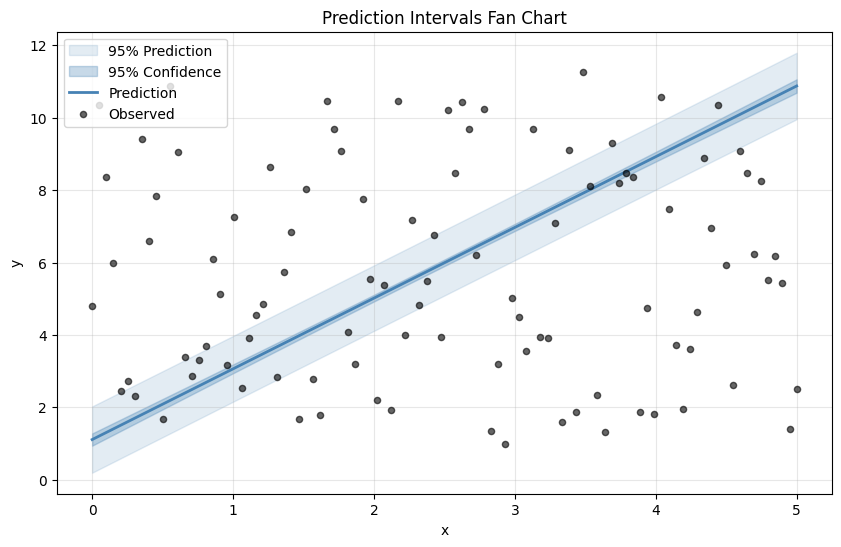

In [9]:
ax = plot_prediction_intervals(model, X_plot, y=jnp.array(y))
ax.set_title("Prediction Intervals Fan Chart")
plt.show()

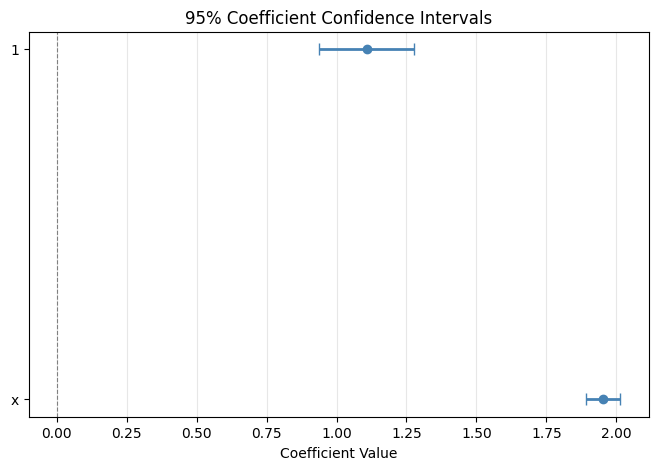

In [10]:
ax = plot_coefficient_intervals(model)
plt.show()

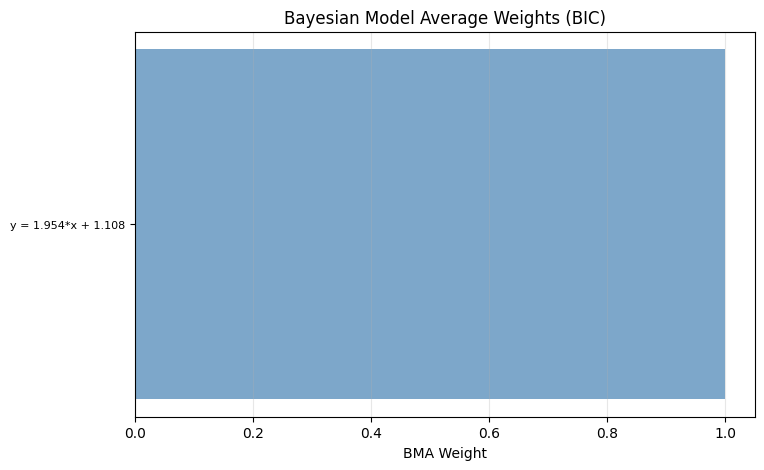

In [11]:
ax = plot_bma_weights(model)
plt.show()